## Loading Libraries

In [4]:
!pip install -q transformers tensorflow_datasets tensorflow-addons vit-keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.8 MB/s eta 0:00:00


In [20]:
import os
import random
import torch
import torchvision
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as L
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from vit_keras import vit, utils, visualize
from keras.models import Model

def seed_everything(seed = 0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed_everything()

In [6]:
from google.colab import drive
drive.mount("/content/drive/")
%cd /content/drive/MyDrive/GNR650/Task-2/

Mounted at /content/drive/
/content/drive/MyDrive/GNR650/Task-2


## Dataloader

In [52]:
classes = ["AnnualCrop", "Forest", "HerbaceousVegetation", "Highway", "Industrial",
          "Pasture", "PermanentCrop", "Residential", "River", "SeaLake"]

In [9]:
DATA_DIR = "./"
ds, ds_info = tfds.load('eurosat/rgb',
                        with_info=True,
                        split='train',
                        data_dir=DATA_DIR)
ds.shuffle(10)
# tfds.show_examples(ds, ds_info);

<_ShuffleDataset element_spec={'filename': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [53]:
for x in ds.take(8):
  label = x['label'].numpy()
  image = x['image'].numpy()
  shape = image.shape

## Helper Functions

In [56]:
def plot_attention_maps(model):
  feature_maps = [image]
  for layer in vit_model.layers[6:17]:
    layer_name = layer.name
    # if "Transformer/encoderblock" in layer_name:
    intermediate_model = Model(inputs=vit_model.input, outputs=vit_model.get_layer(layer_name).output)
    attention_map = visualize.attention_map(model=intermediate_model, image=image)
    feature_maps.append(attention_map)
  image_list = feature_maps
  batch_size = 3
  num_batches = len(image_list) // batch_size + (len(image_list) % batch_size > 0)
  for batch_num in range(num_batches):
      start_idx = batch_num * batch_size
      end_idx = start_idx + batch_size
      # Create a figure with subplots for the batch of images
      fig, axes = plt.subplots(1, batch_size, figsize=(15, 5))
      for i, ax in enumerate(axes):
          if start_idx + i < len(image_list):
              ax.imshow(image_list[start_idx + i])
              if i+start_idx==0:
                ax.set_title(f"Original Image")
              else:
                ax.set_title(f"Encoder_block{start_idx + i + 1}")
              ax.axis("off")
      plt.tight_layout()
      plt.show()

## Loading ViT Model

In [60]:
# Load a model
image_size = 64
vit_model = vit.vit_b16(
    image_size=image_size,
    activation='softmax',
    pretrained=True,
    include_top=True,
    pretrained_top=False,
    classes=10
)

In [33]:
# attention_map = visualize.attention_map(model=vit_model, image=image)
# print(
#     'Prediction:',
#     classes[vit_model.predict(vit.preprocess_inputs(image)[np.newaxis])[0].argmax()])
# print('Label:',
#     classes[label-1]
# )
# # Plot results
# fig, (ax1, ax2) = plt.subplots(ncols=2)
# ax1.axis('off')
# ax2.axis('off')
# ax1.set_title('Original')
# ax2.set_title('Attention Map')
# _ = ax1.imshow(image)
# _ = ax2.imshow(attention_map)

In [61]:
vit_model.summary()

Model: "vit-b16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 embedding (Conv2D)          (None, 4, 4, 768)         590592    
                                                                 
 reshape_4 (Reshape)         (None, 16, 768)           0         
                                                                 
 class_token (ClassToken)    (None, 17, 768)           768       
                                                                 
 Transformer/posembed_input   (None, 17, 768)          13056     
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 17, 768),        7087872   
 (TransformerBlock)           (None, 12, None, None))      

In [78]:
# for layer in vit_model.layers[5:]:
#     print(layer.name)

Transformer/encoderblock_0
Transformer/encoderblock_1
Transformer/encoderblock_2
Transformer/encoderblock_3


## Inference on pre-trained Transformer

1/1 [==============================] - 3s 3s/step


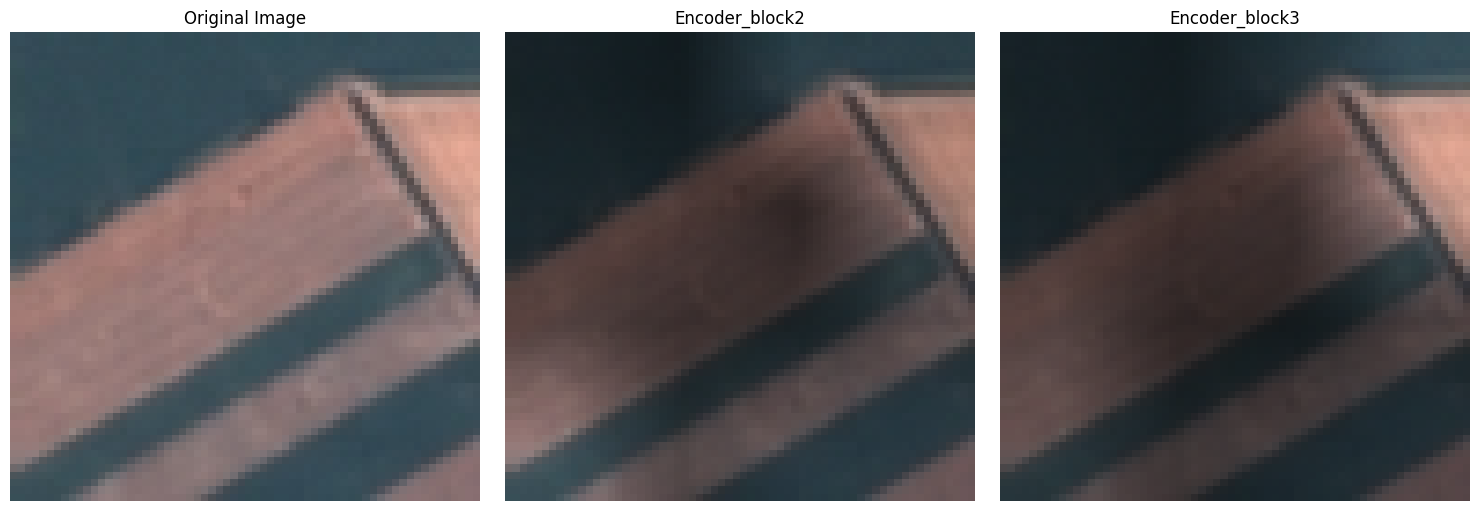

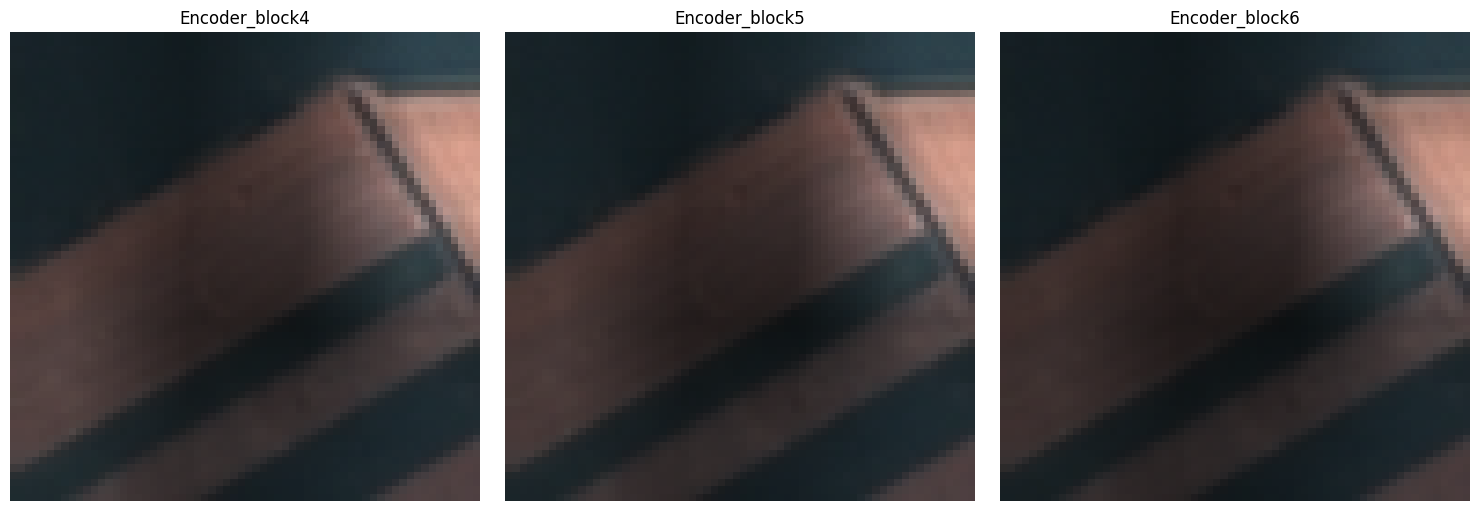

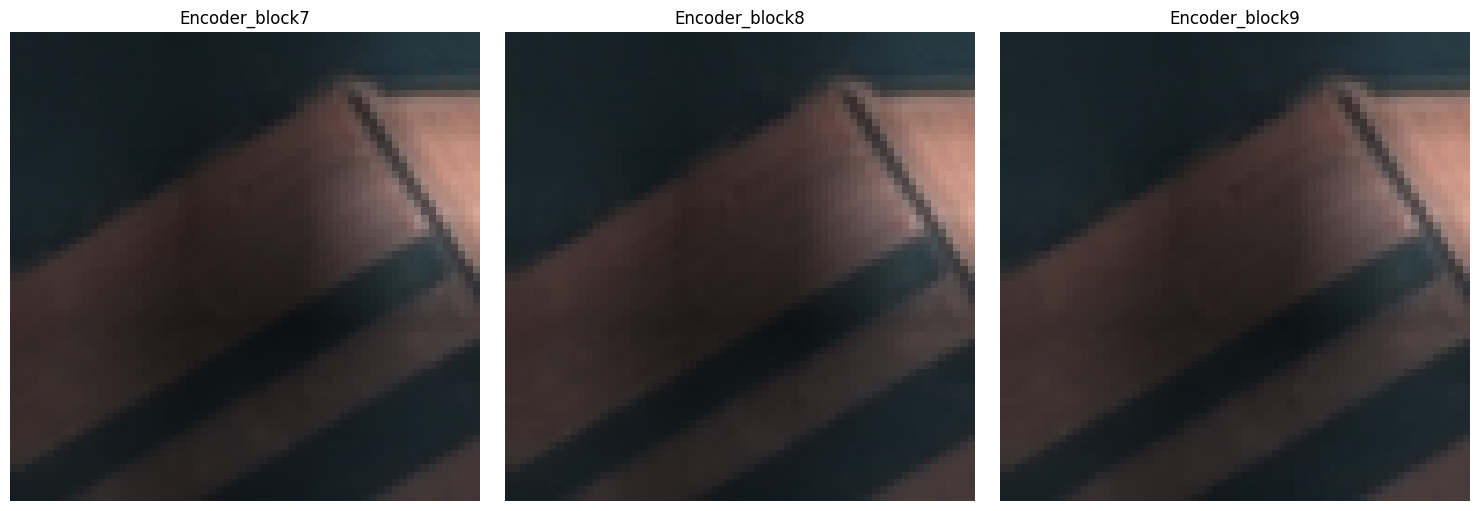

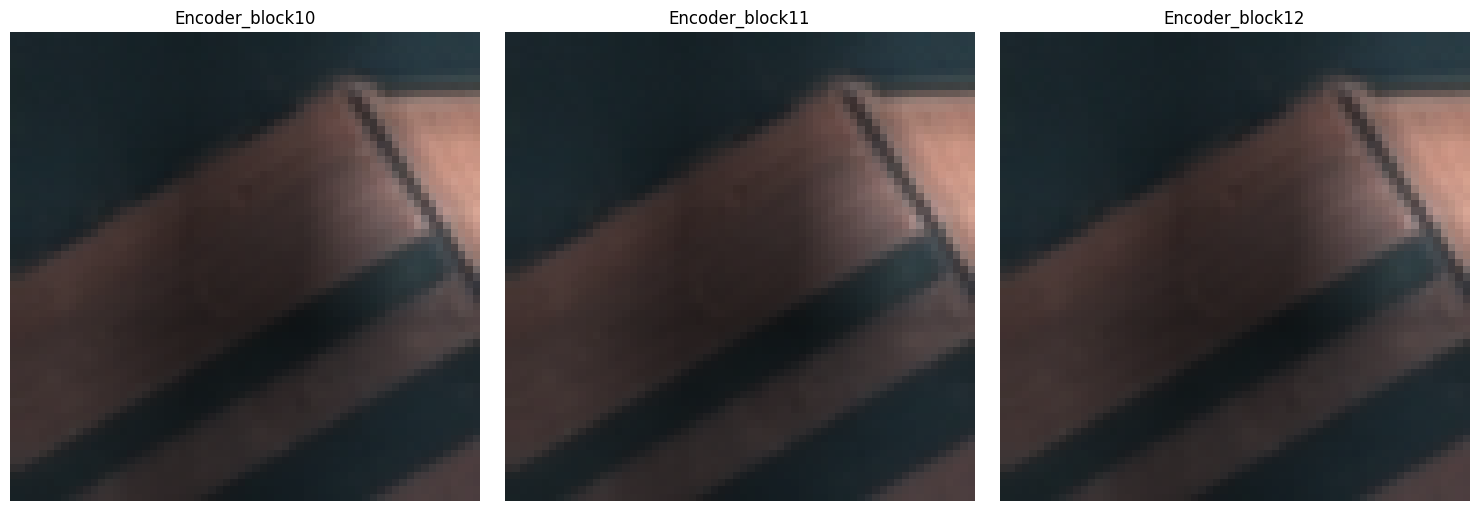

In [57]:
plot_attention_maps(vit_model)

# Fine-Tuning Model

## Full Model Training

In [58]:
X, y = [], []
for data in ds:
  X.append(data['image'])
  one_hot_vector = [0]*10
  one_hot_vector[data['label']] = 1
  y.append(one_hot_vector)
X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [62]:
batch_size = 64
epochs = 20
for layer in vit_model.layers:
    layer.trainable = True

loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# for layer in vit_model.layers[:-1]:
#     layer.trainable = False

vit_model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
history = vit_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

Epoch 1/20
304/304 [==============================] - 136s 283ms/step - loss: 0.9659 - accuracy: 0.6516 - val_loss: 0.7106 - val_accuracy: 0.7529
Epoch 2/20
304/304 [==============================] - 87s 286ms/step - loss: 0.5479 - accuracy: 0.8030 - val_loss: 0.5281 - val_accuracy: 0.8158
Epoch 3/20
304/304 [==============================] - 87s 285ms/step - loss: 0.3825 - accuracy: 0.8643 - val_loss: 0.5811 - val_accuracy: 0.8080
Epoch 4/20
304/304 [==============================] - 87s 284ms/step - loss: 0.2565 - accuracy: 0.9079 - val_loss: 0.6735 - val_accuracy: 0.7951
Epoch 5/20
304/304 [==============================] - 86s 284ms/step - loss: 0.1779 - accuracy: 0.9397 - val_loss: 0.5256 - val_accuracy: 0.8366
Epoch 6/20
304/304 [==============================] - 88s 290ms/step - loss: 0.1141 - accuracy: 0.9632 - val_loss: 0.6227 - val_accuracy: 0.8307
Epoch 7/20
304/304 [==============================] - 88s 290ms/step - loss: 0.0747 - accuracy: 0.9771 - val_loss: 0.5858 - val_a

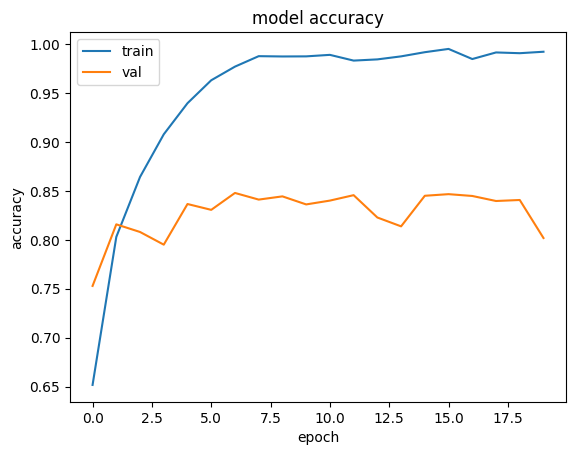

In [63]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [65]:
vit_model.save('full_fine-tuned_model.keras')

In [66]:
vit_model.evaluate(X_test, y_test)

85/85 [==============================] - 5s 59ms/step - loss: 0.9838 - accuracy: 0.8078


[0.9838235378265381, 0.8077777624130249]

1/1 [==============================] - 3s 3s/step


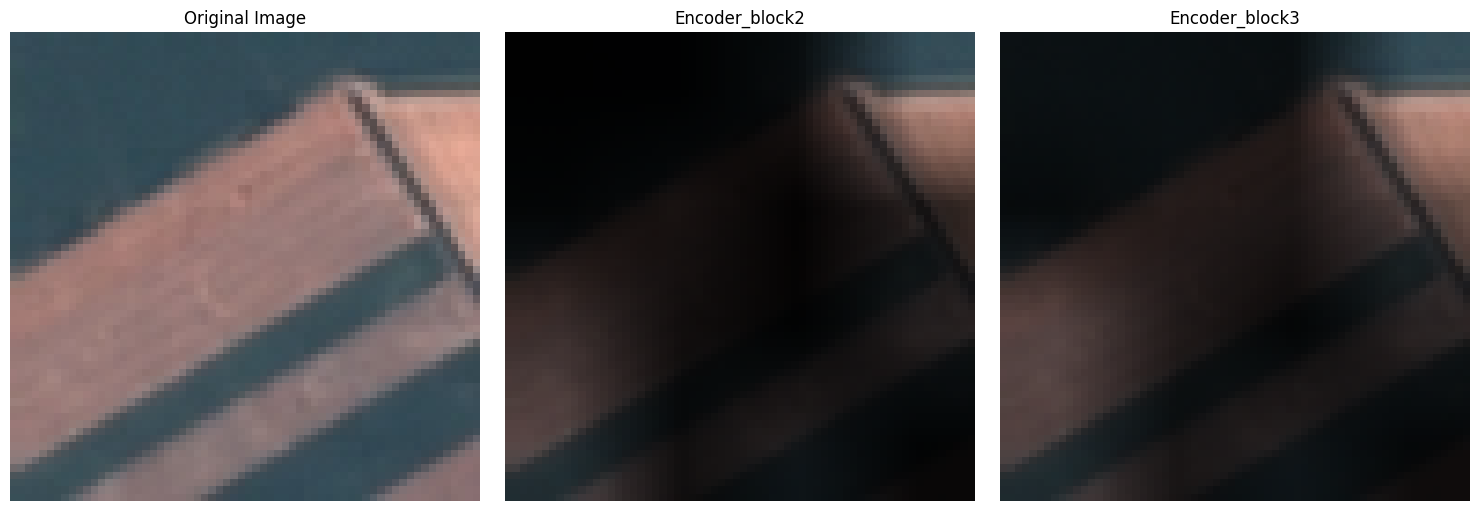

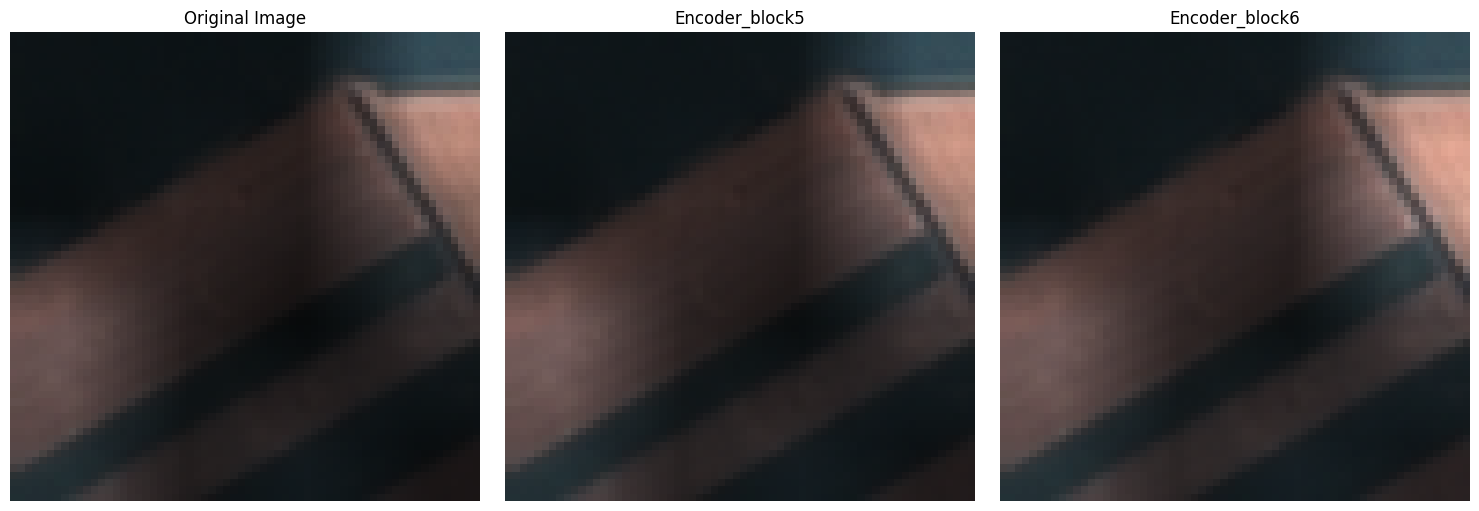

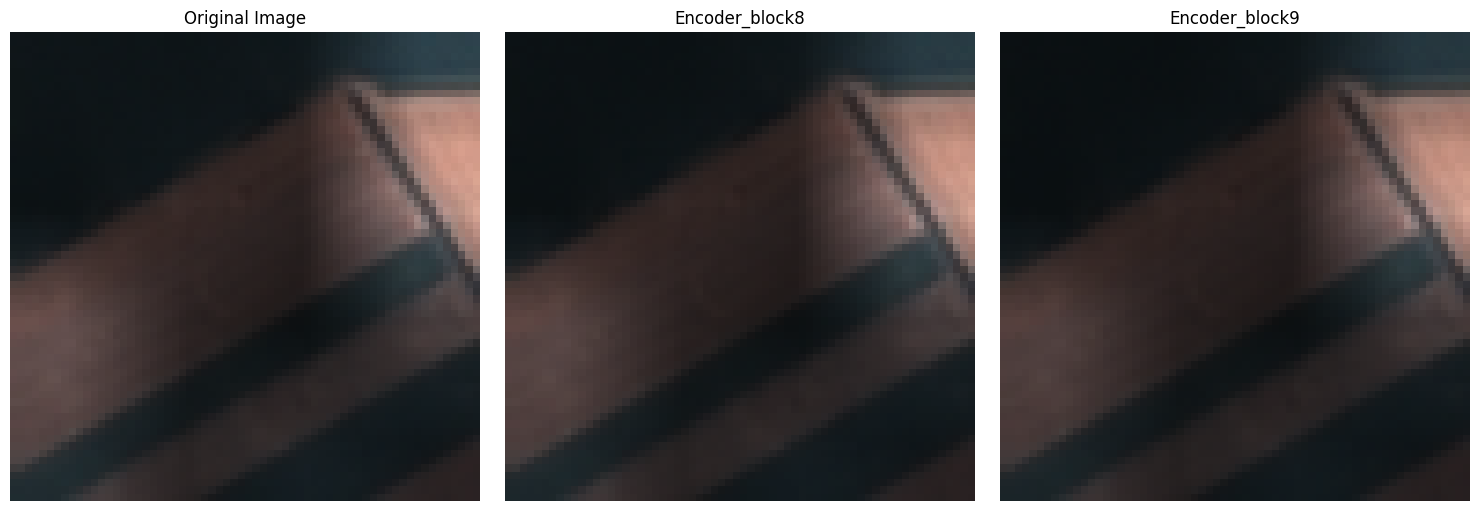

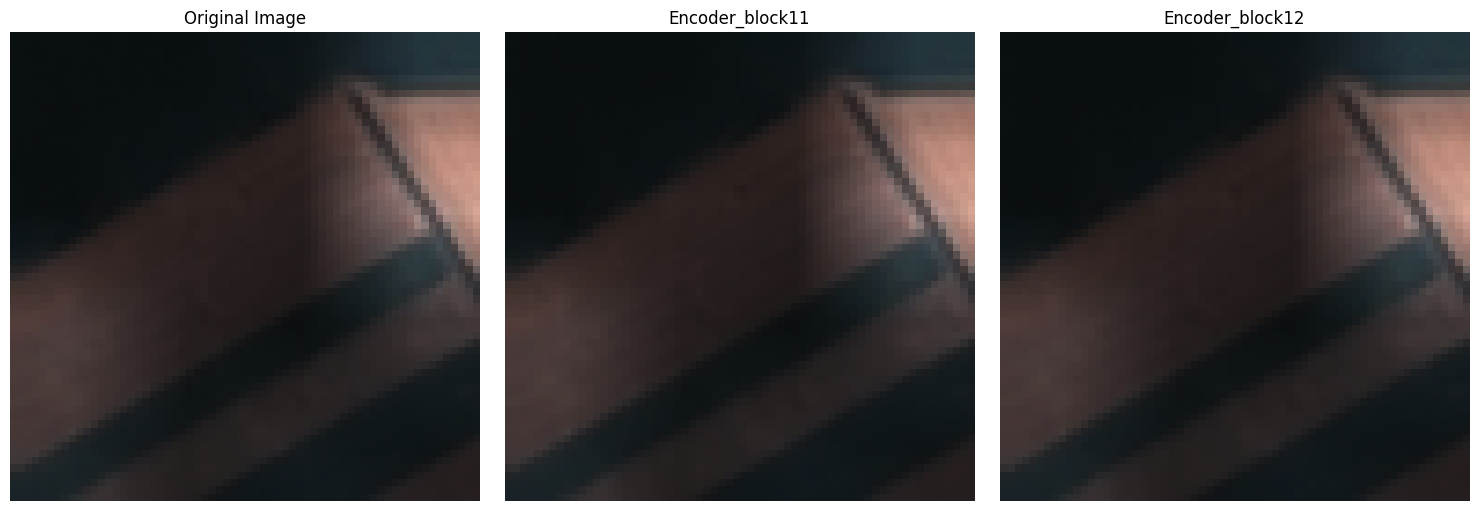

In [32]:
plot_attention_maps(vit_model)

## Fine-Tune Final Transformer Layer

In [67]:
# Load a model
image_size = 64
vit_model_final_ft = vit.vit_b16(
    image_size=image_size,
    activation='softmax',
    pretrained=True,
    include_top=True,
    pretrained_top=False,
    classes=10
)

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 4, 4
  warnings.warn(


In [68]:
batch_size = 64
epochs = 20

for layer in vit_model_final_ft.layers:
    layer.trainable = False

vit_model_final_ft.layers[-1].trainable = True
vit_model_final_ft.layers[-4].trainable = True

loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

vit_model_final_ft.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
history = vit_model_final_ft.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

Epoch 1/20
304/304 [==============================] - 65s 140ms/step - loss: 1.1567 - accuracy: 0.5796 - val_loss: 0.8822 - val_accuracy: 0.6741
Epoch 2/20
304/304 [==============================] - 45s 147ms/step - loss: 0.7727 - accuracy: 0.7241 - val_loss: 0.7286 - val_accuracy: 0.7432
Epoch 3/20
304/304 [==============================] - 43s 142ms/step - loss: 0.6398 - accuracy: 0.7713 - val_loss: 0.6668 - val_accuracy: 0.7702
Epoch 4/20
304/304 [==============================] - 42s 140ms/step - loss: 0.5602 - accuracy: 0.7995 - val_loss: 0.6310 - val_accuracy: 0.7823
Epoch 5/20
304/304 [==============================] - 39s 129ms/step - loss: 0.4927 - accuracy: 0.8253 - val_loss: 0.6890 - val_accuracy: 0.7640
Epoch 6/20
304/304 [==============================] - 43s 141ms/step - loss: 0.4391 - accuracy: 0.8436 - val_loss: 0.6016 - val_accuracy: 0.7940
Epoch 7/20
304/304 [==============================] - 43s 142ms/step - loss: 0.3929 - accuracy: 0.8570 - val_loss: 0.6311 - val_ac

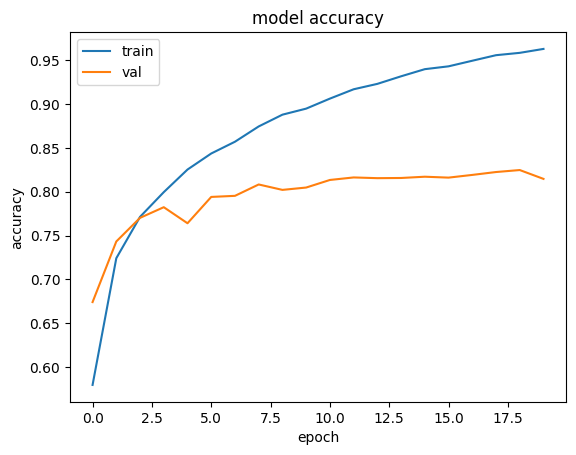

In [69]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

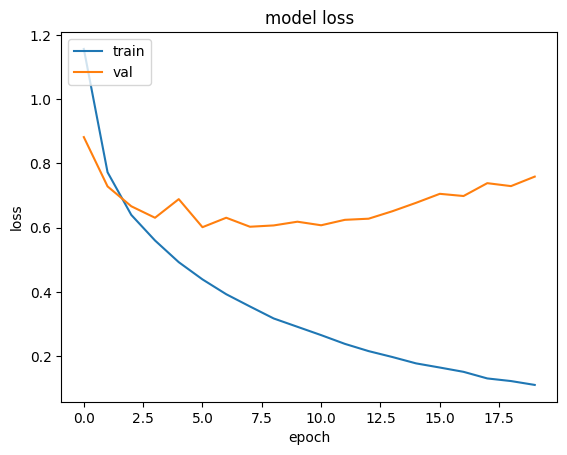

In [72]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [70]:
vit_model_final_ft.save('final_layer_fine-tuned_model.keras')

1/1 [==============================] - 3s 3s/step


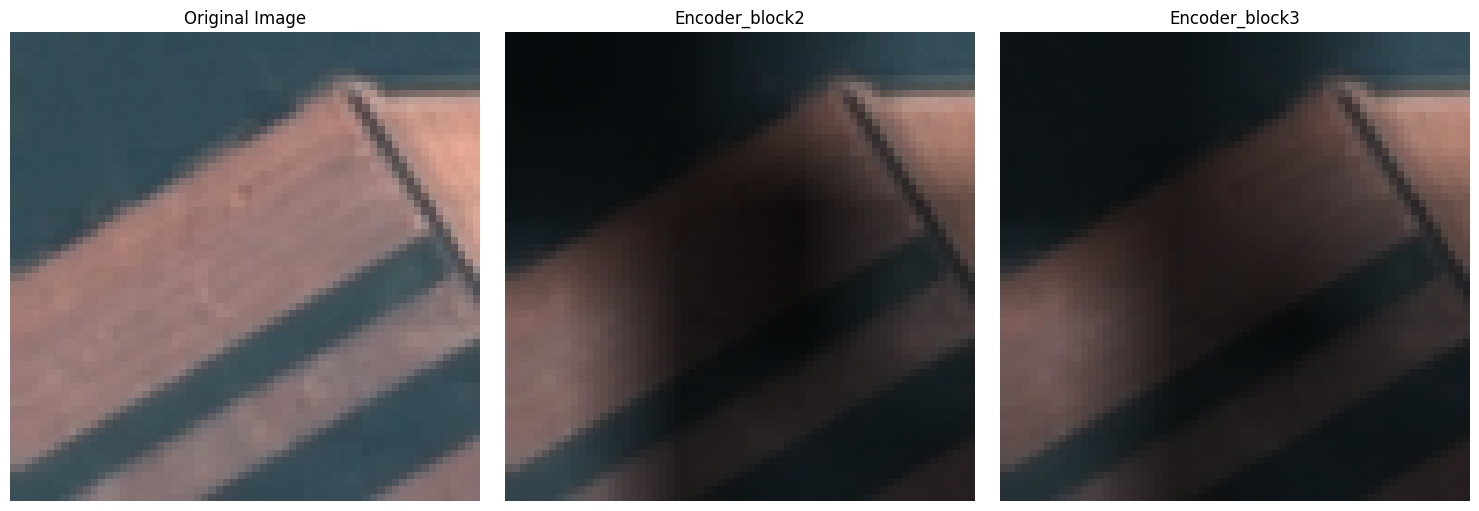

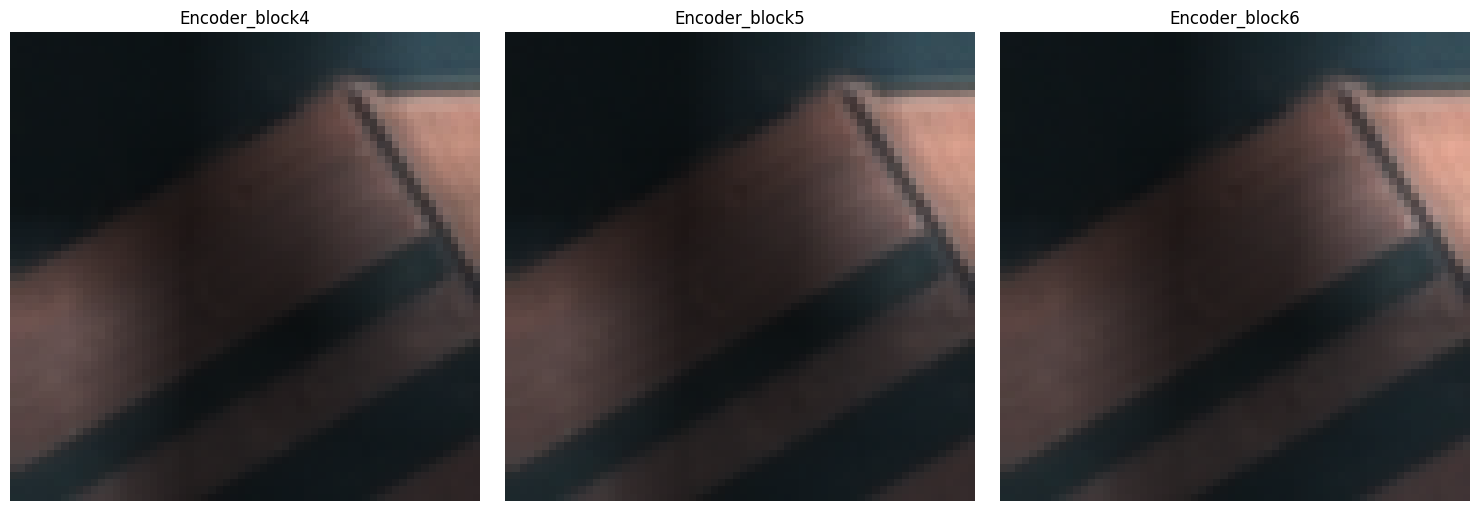

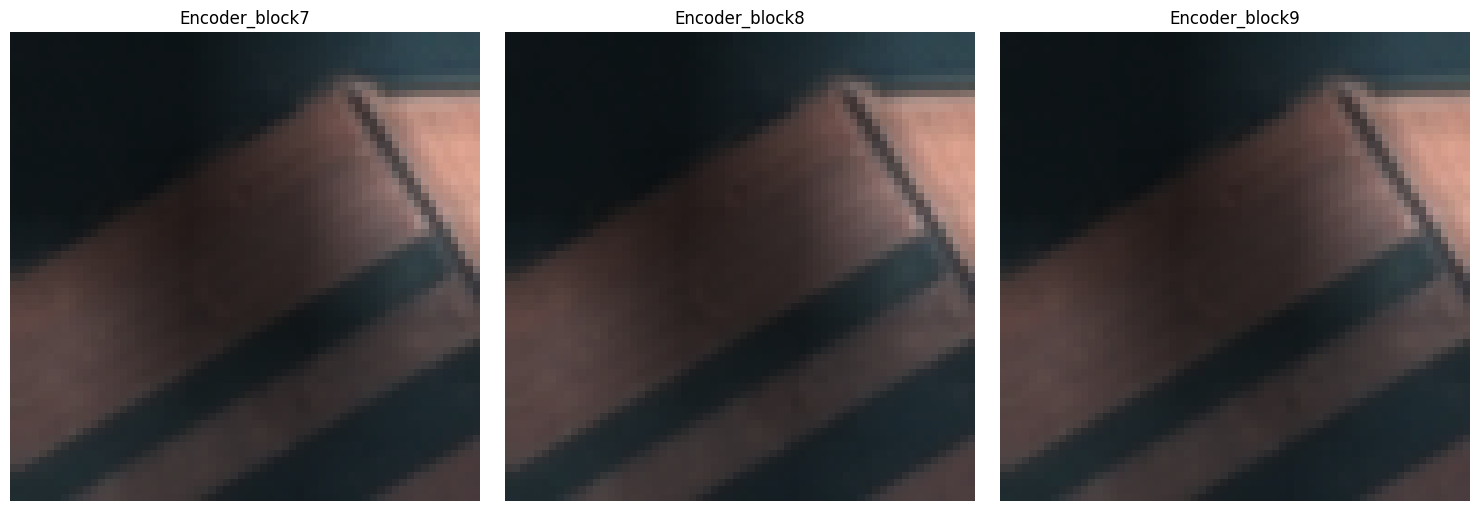

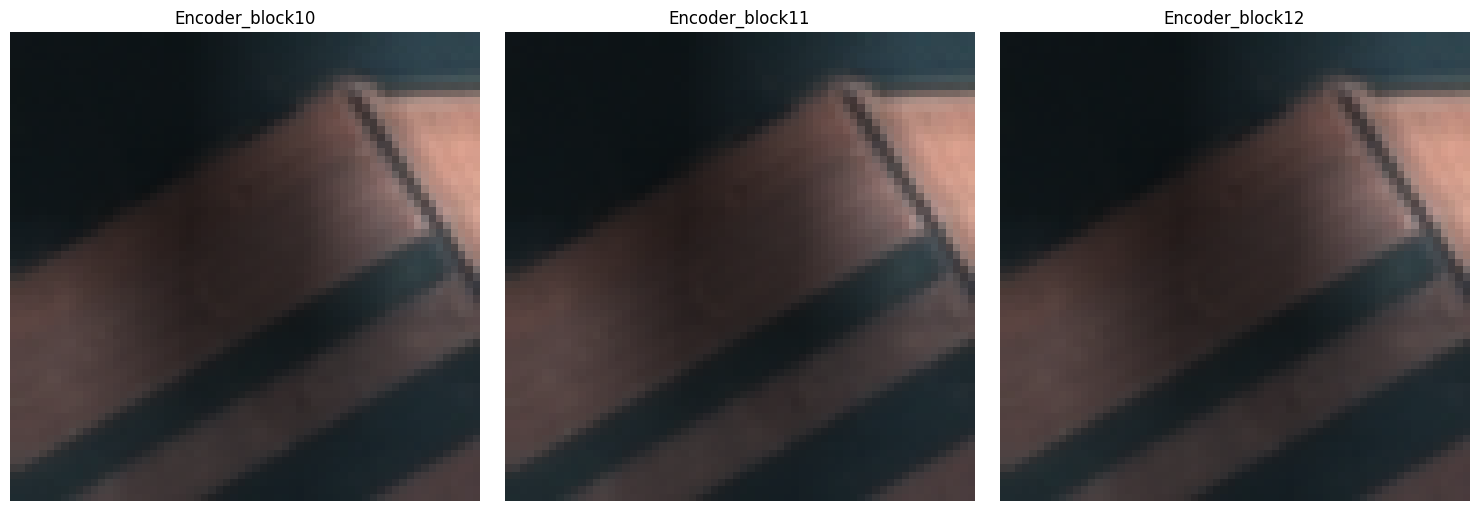

In [73]:
plot_attention_maps(vit_model_final_ft)

In [82]:
vit_model_final_ft.evaluate(X_test, y_test)

85/85 [==============================] - 7s 54ms/step - loss: 0.6817 - accuracy: 0.8263


[0.6817453503608704, 0.8262962698936462]

## Fine-Tune Bottom 4 Layer

In [75]:
# Load a model
image_size = 64
vit_model_bottom4_ft = vit.vit_b16(
    image_size=image_size,
    activation='softmax',
    pretrained=True,
    include_top=True,
    pretrained_top=False,
    classes=10
)

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 4, 4
  warnings.warn(


In [81]:
batch_size = 64
epochs = 20

for layer in vit_model_bottom4_ft.layers:
    layer.trainable = False

vit_model_bottom4_ft.layers[-1].trainable = True
for layer in vit_model_bottom4_ft.layers[5:9]:
  layer.trainable = True

loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

vit_model_bottom4_ft.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
history = vit_model_bottom4_ft.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

Epoch 1/20
304/304 [==============================] - 105s 259ms/step - loss: 1.2047 - accuracy: 0.5623 - val_loss: 0.8551 - val_accuracy: 0.7012
Epoch 2/20
304/304 [==============================] - 72s 237ms/step - loss: 0.7347 - accuracy: 0.7370 - val_loss: 0.6617 - val_accuracy: 0.7786
Epoch 3/20
304/304 [==============================] - 71s 234ms/step - loss: 0.5928 - accuracy: 0.7864 - val_loss: 0.5728 - val_accuracy: 0.8012
Epoch 4/20
304/304 [==============================] - 73s 240ms/step - loss: 0.5020 - accuracy: 0.8199 - val_loss: 0.5234 - val_accuracy: 0.8237
Epoch 5/20
304/304 [==============================] - 70s 229ms/step - loss: 0.4214 - accuracy: 0.8497 - val_loss: 0.4958 - val_accuracy: 0.8309
Epoch 6/20
304/304 [==============================] - 73s 240ms/step - loss: 0.3570 - accuracy: 0.8735 - val_loss: 0.5363 - val_accuracy: 0.8274
Epoch 7/20
304/304 [==============================] - 70s 229ms/step - loss: 0.2945 - accuracy: 0.8964 - val_loss: 0.5125 - val_a

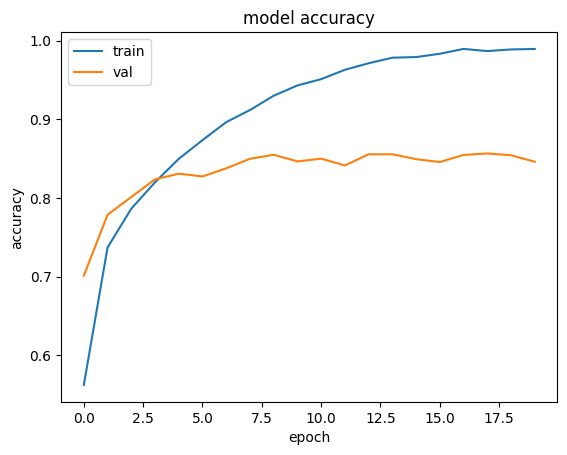

In [83]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

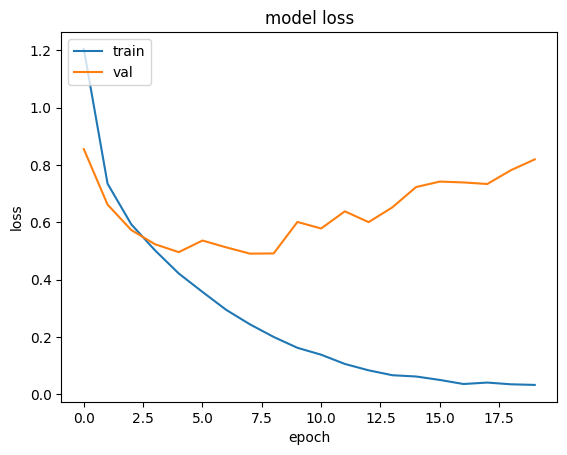

In [84]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [85]:
vit_model_bottom4_ft.save('bottom4_fine-tuned_model.keras')

1/1 [==============================] - 3s 3s/step


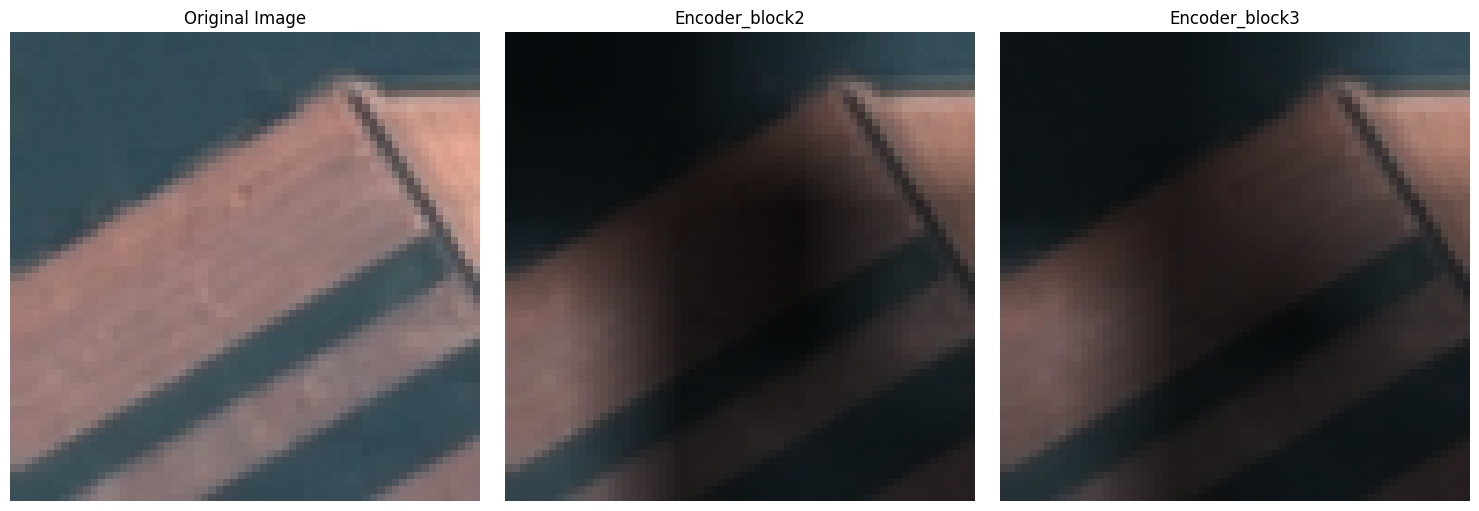

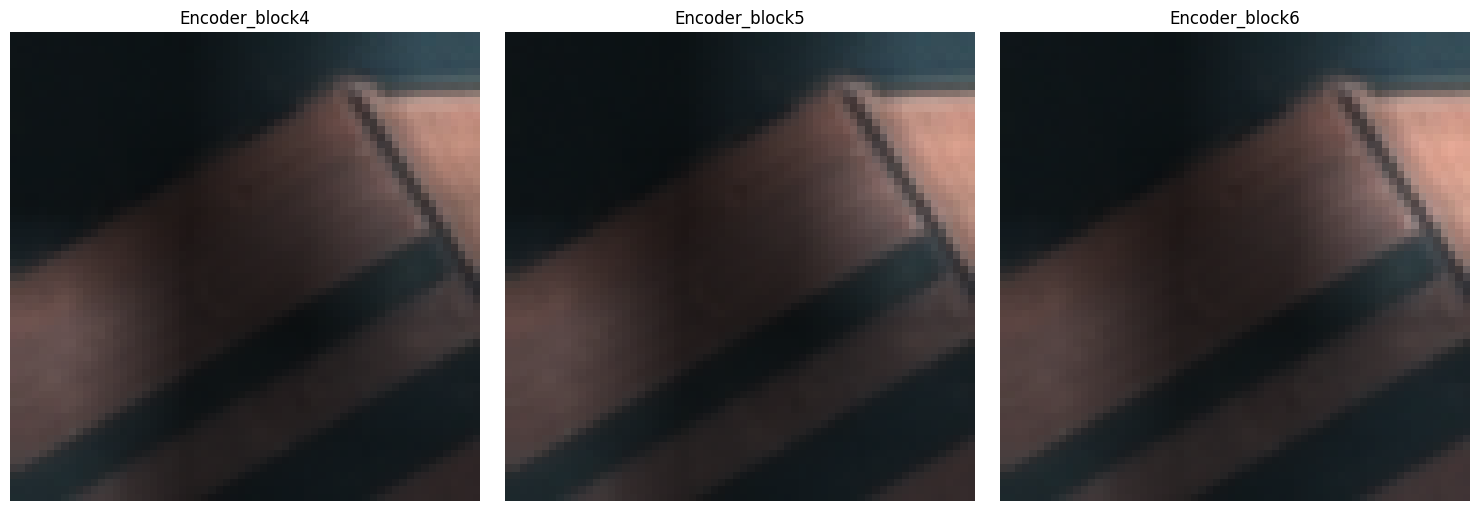

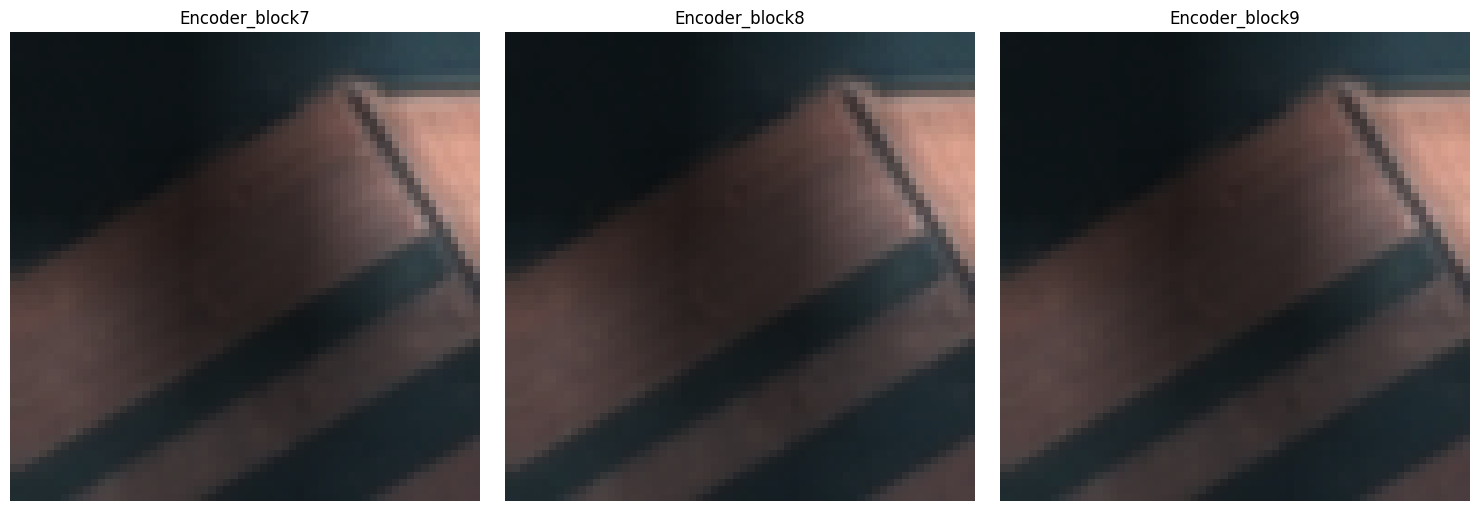

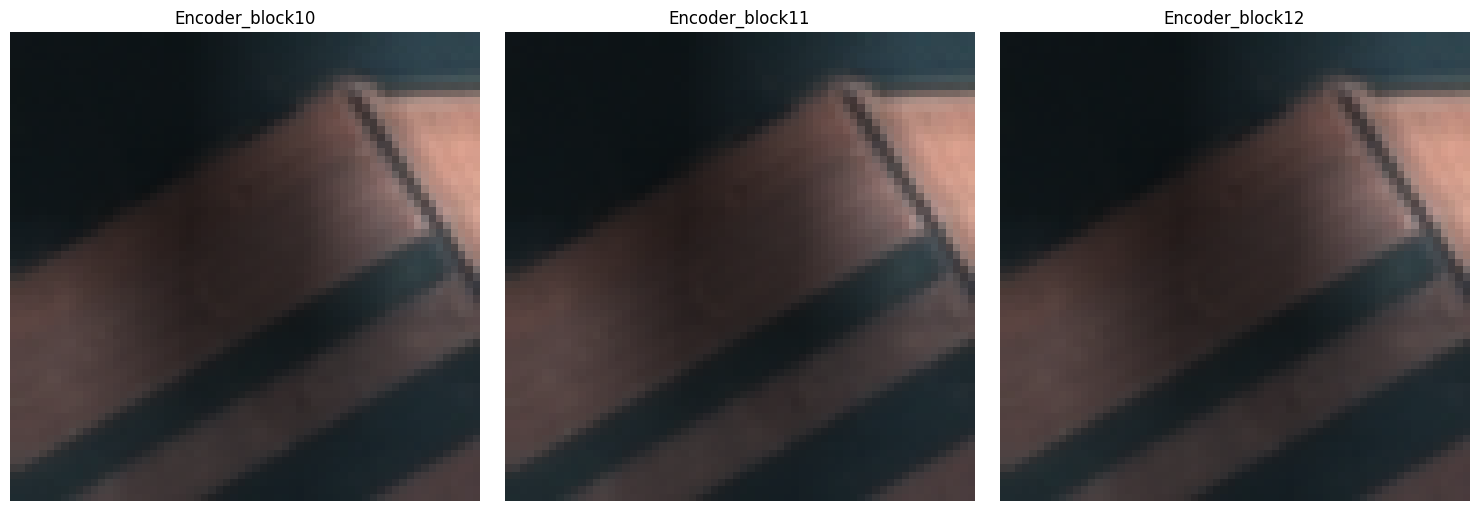

In [86]:
plot_attention_maps(vit_model_bottom4_ft)

In [87]:
vit_model_bottom4_ft.evaluate(X_test, y_test)

85/85 [==============================] - 5s 53ms/step - loss: 0.7633 - accuracy: 0.8396


[0.7633291482925415, 0.8396296501159668]

## Fine-Tune Dense Layer (No Fine-tune case)

It doesn't makes sense to not train the dense layers formaking the final prediction as the model was pre-trained on imagenet data set thousands of classes. The number of classes have changed to 10 & hence only dense layers are trained and none of the transformer layers



In [88]:
# Load a model
image_size = 64
vit_model_no_ft = vit.vit_b16(
    image_size=image_size,
    activation='softmax',
    pretrained=True,
    include_top=True,
    pretrained_top=False,
    classes=10
)

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 4, 4
  warnings.warn(


In [96]:
batch_size = 64
epochs = 20

for layer in vit_model_no_ft.layers:
    layer.trainable = False

vit_model_no_ft.layers[-1].trainable = True

loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

vit_model_no_ft.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
history = vit_model_no_ft.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

Epoch 1/20
304/304 [==============================] - 61s 141ms/step - loss: 0.7813 - accuracy: 0.7160 - val_loss: 0.7388 - val_accuracy: 0.7422
Epoch 2/20
304/304 [==============================] - 42s 140ms/step - loss: 0.7780 - accuracy: 0.7184 - val_loss: 0.7327 - val_accuracy: 0.7479
Epoch 3/20
304/304 [==============================] - 39s 130ms/step - loss: 0.7823 - accuracy: 0.7166 - val_loss: 0.7392 - val_accuracy: 0.7352
Epoch 4/20
304/304 [==============================] - 39s 130ms/step - loss: 0.7786 - accuracy: 0.7184 - val_loss: 0.7475 - val_accuracy: 0.7270
Epoch 5/20
304/304 [==============================] - 36s 117ms/step - loss: 0.7758 - accuracy: 0.7157 - val_loss: 0.7321 - val_accuracy: 0.7438
Epoch 6/20
304/304 [==============================] - 39s 130ms/step - loss: 0.7805 - accuracy: 0.7158 - val_loss: 0.7400 - val_accuracy: 0.7348
Epoch 7/20
304/304 [==============================] - 36s 117ms/step - loss: 0.7735 - accuracy: 0.7164 - val_loss: 0.7318 - val_ac

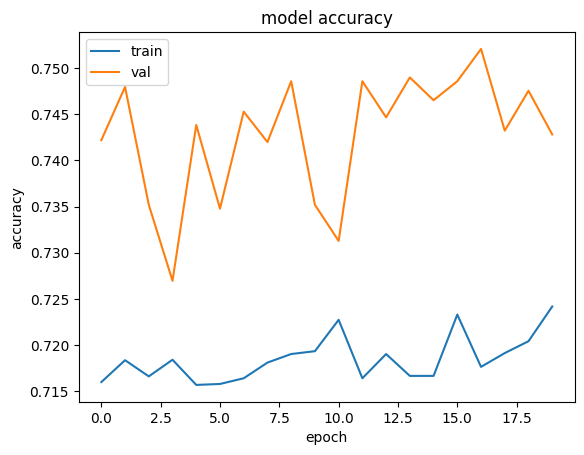

In [97]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

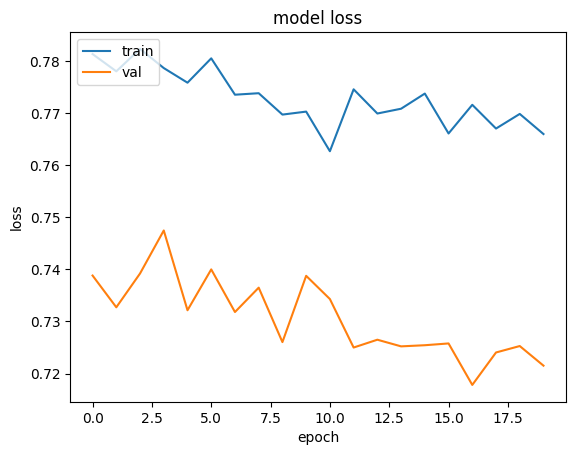

In [98]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [99]:
vit_model_no_ft.save('No_fine-tuned_model.keras')

1/1 [==============================] - 3s 3s/step


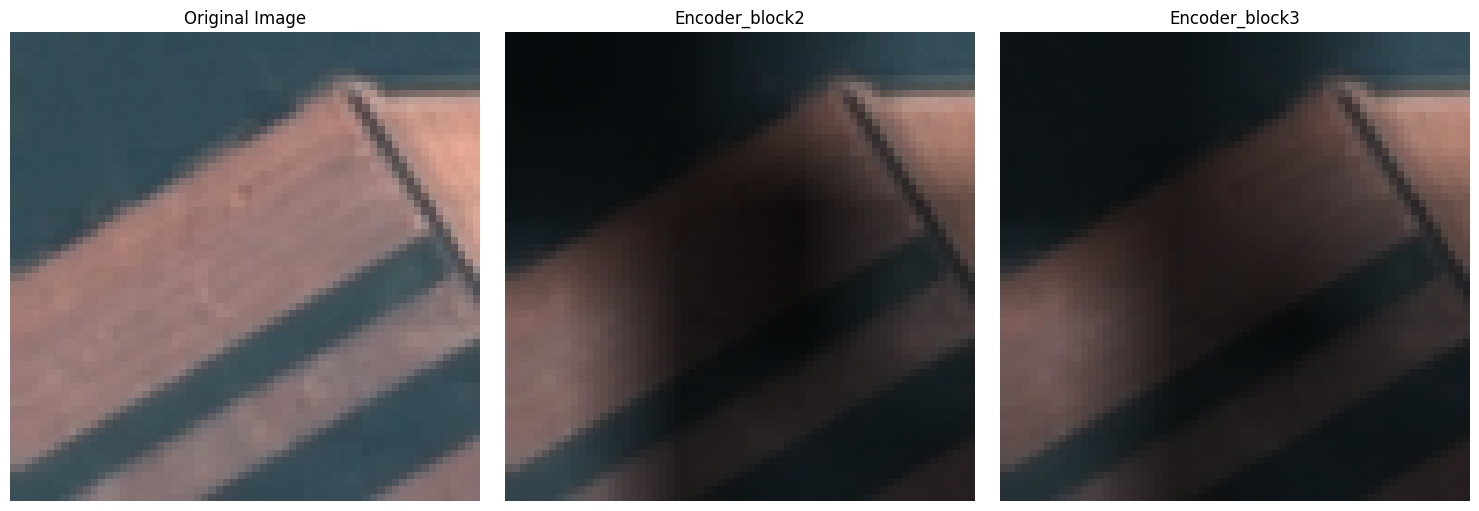

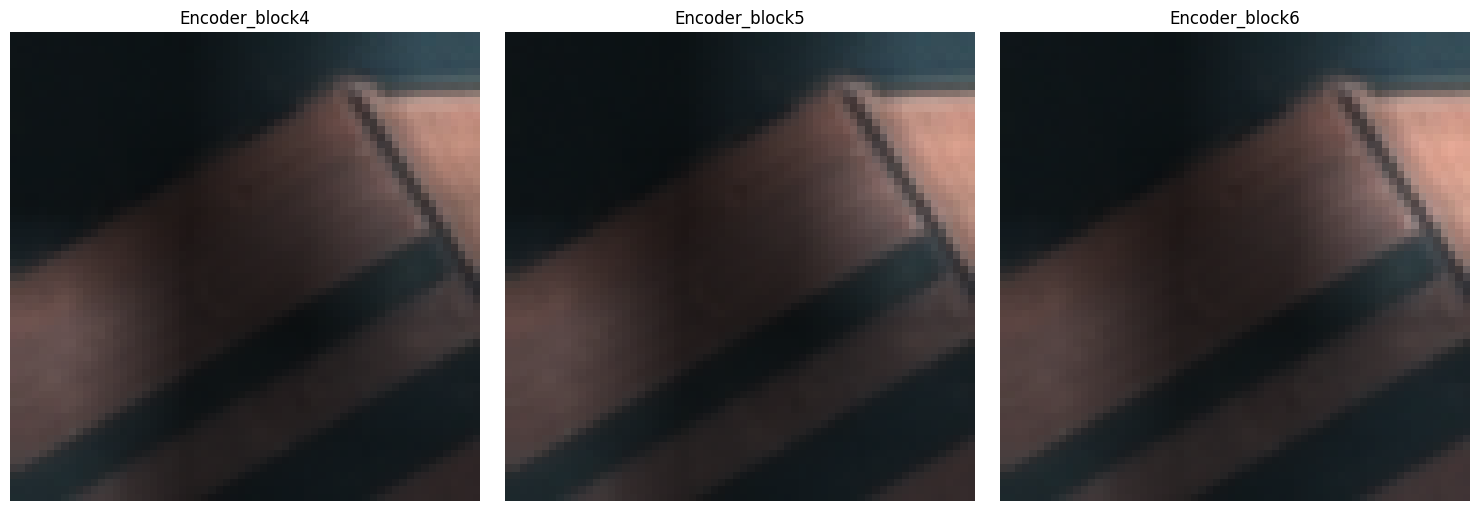

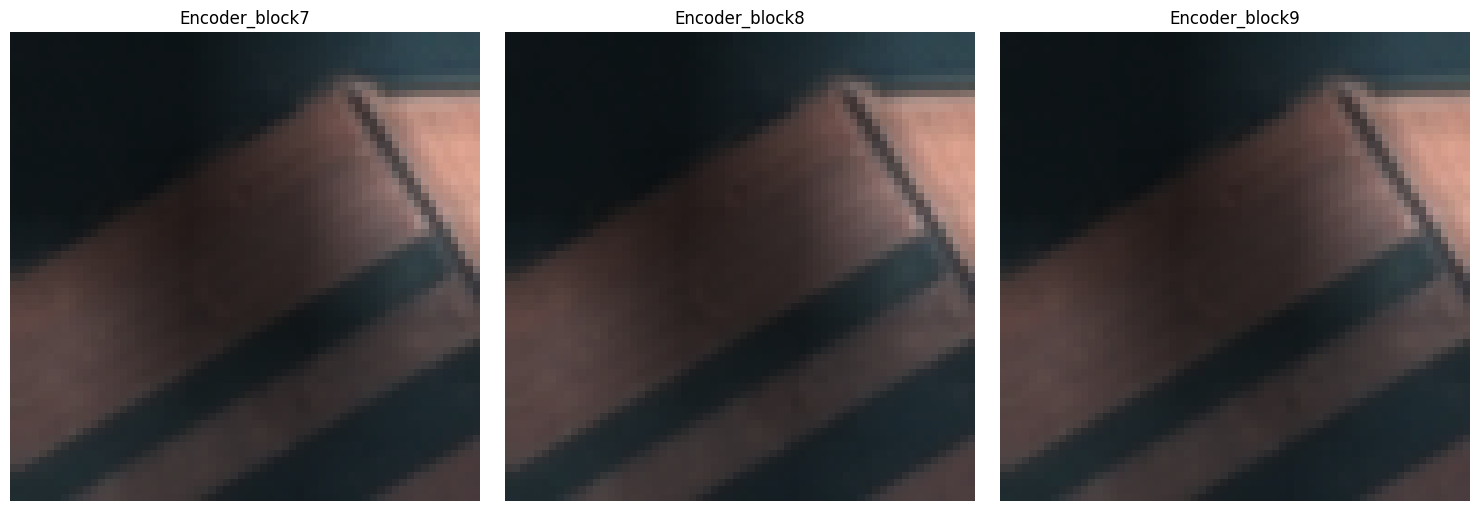

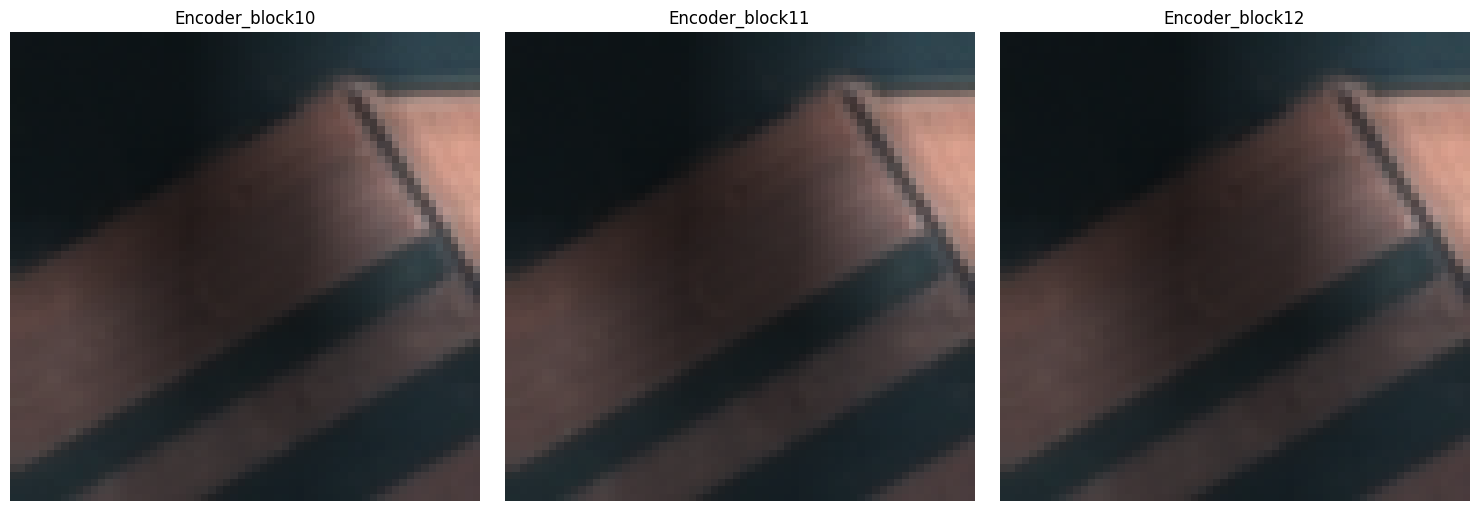

In [100]:
plot_attention_maps(vit_model_no_ft)

In [101]:
vit_model_no_ft.evaluate(X_test, y_test)

85/85 [==============================] - 5s 58ms/step - loss: 0.7202 - accuracy: 0.7463


[0.7202398180961609, 0.7462962865829468]

### By comparing we can see model